In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [81]:
df = pd.read_csv('WeatherData/Quezon City Weather Data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df = df[['temp']].copy()
df = df.fillna(method='ffill')
df.tail(5)

C:\Users\User\AppData\Local\Temp\ipykernel_12944\4170967098.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,temp
datetime,
2025-04-10,30.8
2025-04-11,31.3
2025-04-12,31.5
2025-04-13,31.2
2025-04-14,31.1


In [91]:
temp_series = df[['temp']]
temp_series

,temp
datetime,
2011-01-01,25.2
2011-01-02,25.3
2011-01-03,25.7
2011-01-04,25.1
2011-01-05,25.4
...,...
2025-04-10,30.8
2025-04-11,31.3
2025-04-12,31.5


In [92]:
scaler = MinMaxScaler(feature_range=(0, 1))
temp_normalized = scaler.fit_transform(temp_series.values)

In [93]:
def create_sequence(data, window_size, forecast_size):
    X, y = [], [] 
    for i in range(len(data) - window_size - forecast_size + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_size])
    return np.array(X), np.array(y)

In [94]:
WINDOW_SIZE = 7;
FORECAST_HORIZON = 3;

In [95]:
X, y = create_sequence(temp_normalized, WINDOW_SIZE, FORECAST_HORIZON)
X.shape, y.shape

((5209, 7, 1), (5209, 3, 1))

In [96]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(5209, 7, 1)

In [97]:
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [98]:
model = Sequential([
    InputLayer((WINDOW_SIZE, 1)),
    LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform'),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(128, kernel_initializer='glorot_uniform'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 7, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,779 (827.26 KB)

 Trainable params: 211,267 (825.26 KB)

 Non-trainable params: 512 (2.00 KB)

In [99]:
optimizer = Adam(learning_rate=0.01)

In [100]:
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=['mse', 'mae']
)

In [101]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
)

In [102]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    restore_best_weights=True
)

In [103]:
os.makedirs('WeatherModels', exist_ok=True)
model_count = len([name for name in os.listdir('WeatherModels') if name.startswith('model')])
model_path = f'WeatherModels/model_{model_count + 1}.keras'

In [104]:
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)

In [105]:
history = model.fit(
    X,
    y,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    validation_split=0.1,
    verbose=1,
)

Epoch 1/100


74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.2146 - mae: 0.2984 - mse: 0.2146 - val_loss: 0.0246 - val_mae: 0.1262 - val_mse: 0.0246 - learning_rate: 0.0100
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0209 - mae: 0.1148 - mse: 0.0209 - val_loss: 0.0482 - val_mae: 0.1841 - val_mse: 0.0482 - learning_rate: 0.0100
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0146 - mae: 0.0955 - mse: 0.0146 - val_loss: 0.0400 - val_mae: 0.1653 - val_mse: 0.0400 - learning_rate: 0.0100
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0123 - mae: 0.0879 - mse: 0.0123 - val_loss: 0.0470 - val_mae: 0.1874 - val_mse: 0.0470 - learning_rate: 0.0100
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0118 - mae: 0.0859 - mse: 0.0118 - val_loss: 0.0387 - val_mae: 0.1652 - val_mse: 0.0387 - learning_rate: 0.0100
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0107 - mae: 0.0810 - mse: 0.0107 - val_loss: 0.0211 - val_mae: 0.1203 - val_mse

In [106]:
best_model = tf.keras.models.load_model(model_path)

In [107]:
def inverse_evaluate(model, X, y, scaler, samples=5):
    predictions = model.predict(X)
    
    # Inverse transform
    y_actual = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
    
    mse_scores = []
    mae_scores = []
    
    for i in range(samples):
        idx = np.random.randint(0, len(X))
        
        plt.figure(figsize=(12, 6))
        # Plot history
        history = scaler.inverse_transform(X[idx].reshape(-1, 1))
        plt.plot(range(WINDOW_SIZE), history, label=f'Last {WINDOW_SIZE} days')
        
        # Plot actual and predicted
        plt.plot(range(WINDOW_SIZE, WINDOW_SIZE + FORECAST_HORIZON), 
                y_actual[idx], 'go-', linewidth=2, markersize=8, label='Actual')
        plt.plot(range(WINDOW_SIZE, WINDOW_SIZE + FORECAST_HORIZON), 
                y_pred[idx], 'ro--', linewidth=2, markersize=8, label='Predicted')
        
        plt.legend()
        plt.title(f'3-Day Forecast Sample {i+1}\nTemperature Prediction')
        plt.xlabel('Days before forecast')
        plt.ylabel('Temperature (°C)')
        plt.grid(True)
        plt.show()
        
        sample_mse = mean_squared_error(y_actual[idx], y_pred[idx])
        sample_mae = np.mean(np.abs(y_actual[idx] - y_pred[idx]))
        mse_scores.append(sample_mse)
        mae_scores.append(sample_mae)
        
        print(f"Sample {i+1}:")
        print(f"Actual temps: {y_actual[idx].round(1)}°C")
        print(f"Predicted temps: {y_pred[idx].round(1)}°C")
        print(f"MSE: {sample_mse:.2f}, MAE: {sample_mae:.2f}°C\n")
    
    print("\nOverall Performance:")
    print(f"Average MSE: {np.mean(mse_scores):.2f}")
    print(f"Average MAE: {np.mean(mae_scores):.2f}°C")
    return y_actual, y_pred

163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


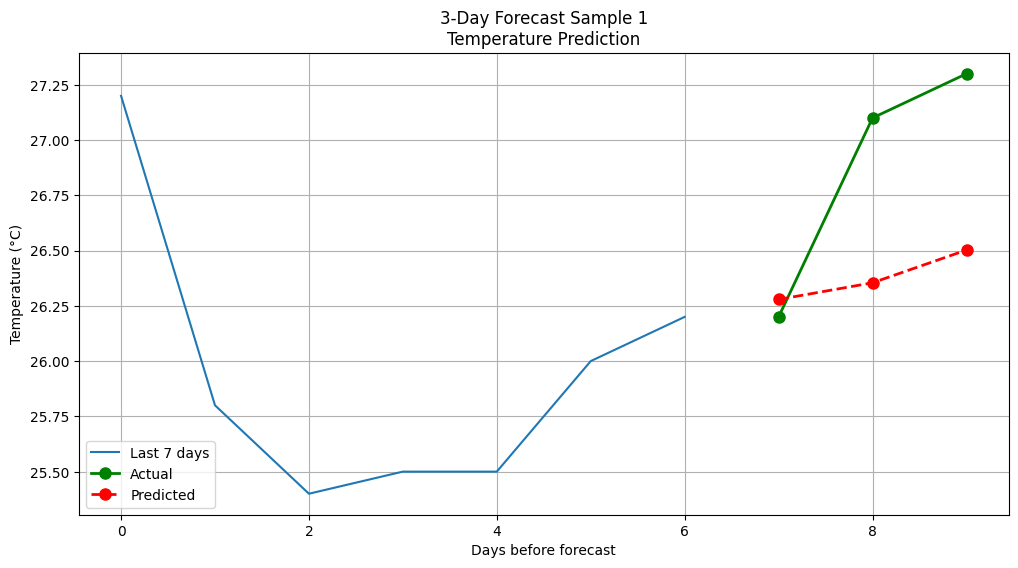

Sample 1:
Actual temps: [[26.2]
 [27.1]
 [27.3]]°C
Predicted temps: [26.3 26.4 26.5]°C
MSE: 0.40, MAE: 0.61°C



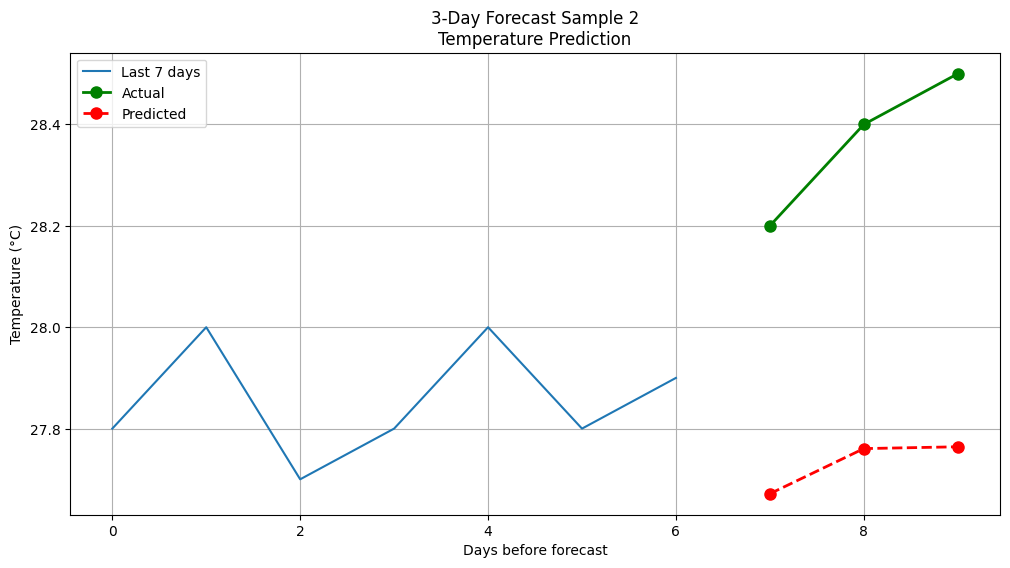

Sample 2:
Actual temps: [[28.2]
 [28.4]
 [28.5]]°C
Predicted temps: [27.7 27.8 27.8]°C
MSE: 0.41, MAE: 0.63°C



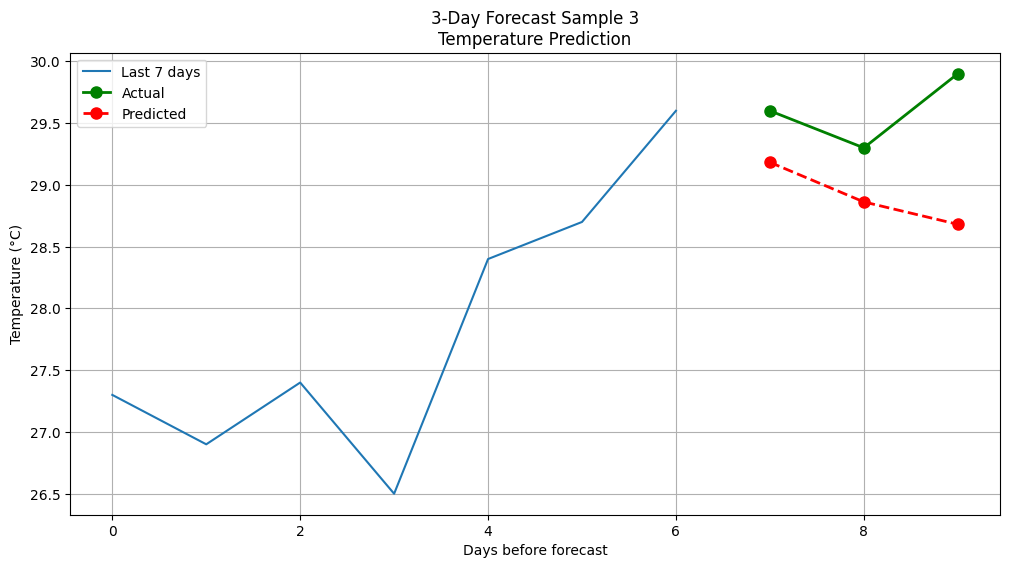

Sample 3:
Actual temps: [[29.6]
 [29.3]
 [29.9]]°C
Predicted temps: [29.2 28.9 28.7]°C
MSE: 0.62, MAE: 0.69°C



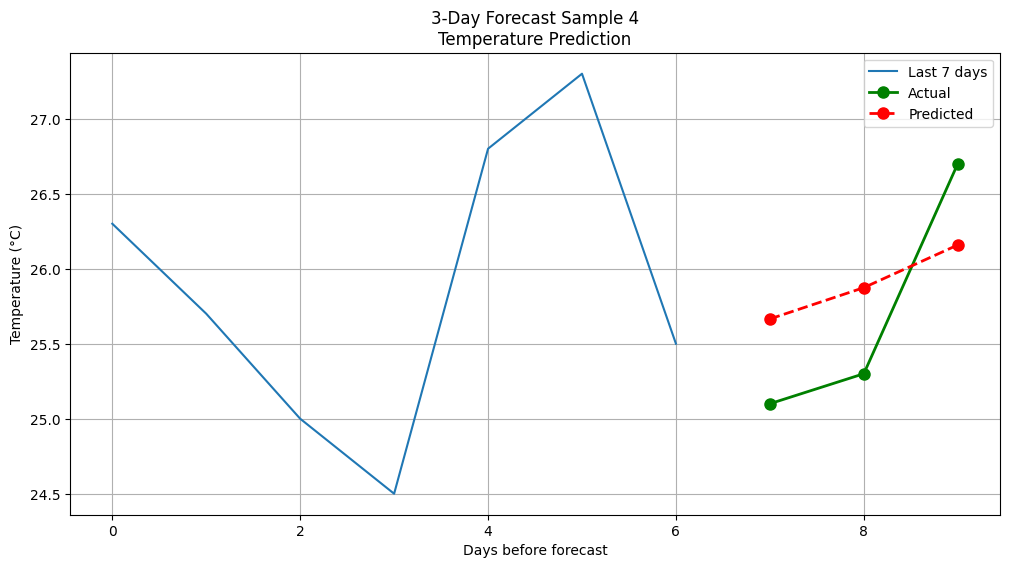

Sample 4:
Actual temps: [[25.1]
 [25.3]
 [26.7]]°C
Predicted temps: [25.7 25.9 26.2]°C
MSE: 0.31, MAE: 0.73°C



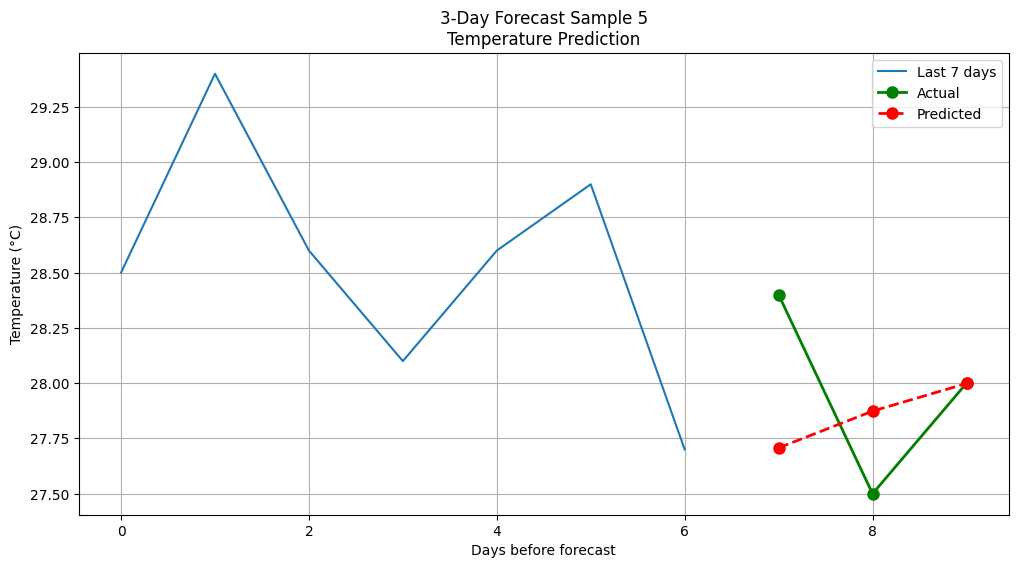

Sample 5:
Actual temps: [[28.4]
 [27.5]
 [28. ]]°C
Predicted temps: [27.7 27.9 28. ]°C
MSE: 0.21, MAE: 0.35°C



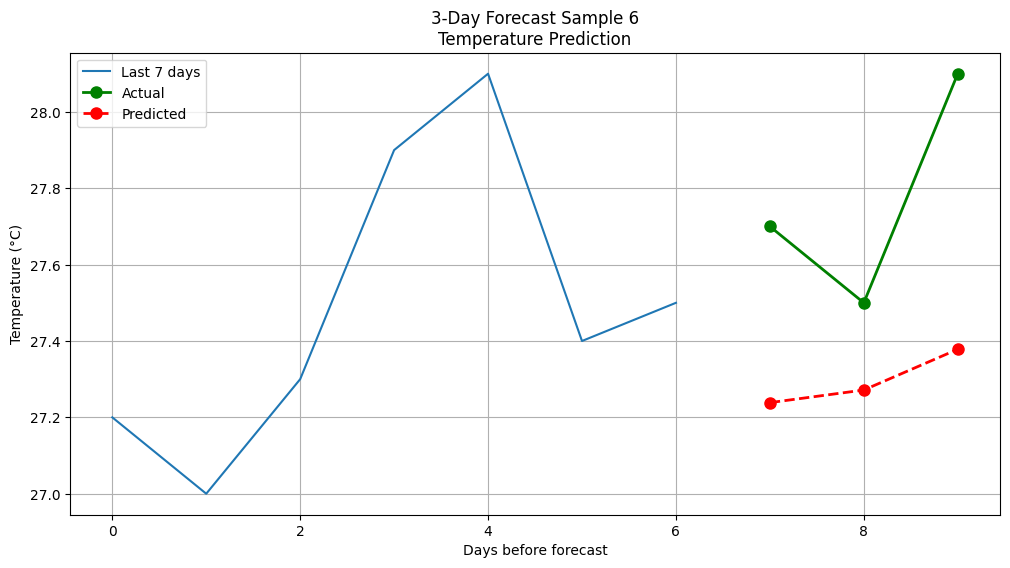

Sample 6:
Actual temps: [[27.7]
 [27.5]
 [28.1]]°C
Predicted temps: [27.2 27.3 27.4]°C
MSE: 0.26, MAE: 0.47°C



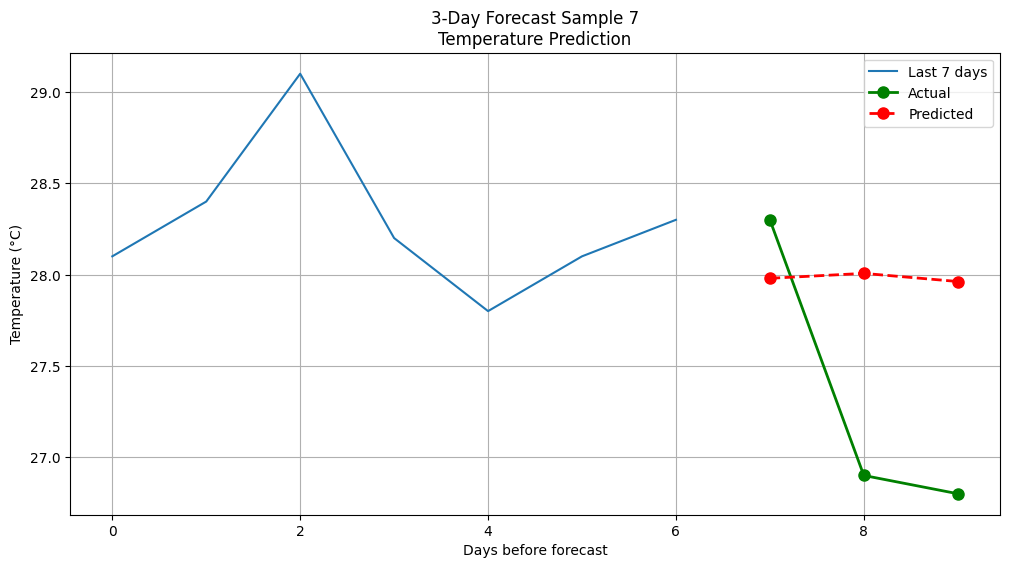

Sample 7:
Actual temps: [[28.3]
 [26.9]
 [26.8]]°C
Predicted temps: [28. 28. 28.]°C
MSE: 0.89, MAE: 0.86°C


Overall Performance:
Average MSE: 0.44
Average MAE: 0.62°C


In [108]:
y_actual, y_pred = inverse_evaluate(best_model, X, y, scaler, samples=7)

In [109]:
df['temp'].describe()

count    5218.000000
mean       28.148294
std         1.495314
min        22.200000
25%        27.100000
50%        28.100000
75%        29.100000
max        32.800000
Name: temp, dtype: float64